# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [22]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

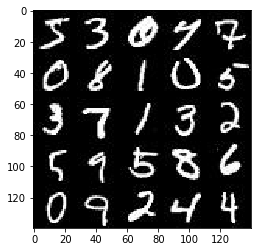

In [23]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

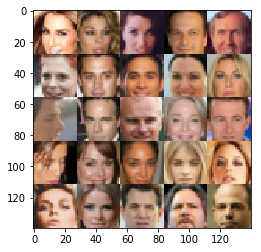

In [24]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [26]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
#    print('model_inputs:', image_width, image_height, image_channels, z_dim)
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    inputs_learning_rate = tf.placeholder(tf.float32, (None), name='input_learning_rate')
    
    return inputs_real, inputs_z, inputs_learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [27]:
import numpy as np
alpha = 0.01

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28*28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        print('discriminator(), relu1', relu1.get_shape())
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        print('discriminator(), relu2', relu2.get_shape())
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        print('discriminator(), relu3', relu3.get_shape())
        # 4x4x256

        # Flatten it
        shape = relu3.get_shape().as_list()
        dim = np.prod(shape[1:])
        flat = tf.reshape(relu2, (-1, dim))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits

def discriminator_dense(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Flatten it
        shape = images.get_shape().as_list()
        dim = np.prod(shape[1:])
        flat = tf.reshape(images, (-1, dim))
        
        # Hidden layer
        h1 = tf.layers.dense(flat, 128, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)
        
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

discriminator(), relu1 (?, 14, 14, 64)
discriminator(), relu2 (?, 7, 7, 128)
discriminator(), relu3 (?, 4, 4, 256)
discriminator(), relu1 (?, 14, 14, 64)
discriminator(), relu2 (?, 7, 7, 128)
discriminator(), relu3 (?, 4, 4, 256)
Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [28]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)

#    with tf.variable_scope('generator', reuse=(not is_train)):
#        
#        # First fully connected layer
#        x1 = tf.layers.dense(z, 3*3*512)
#        # Reshape it to start the convolutional stack
#        x1 = tf.reshape(x1, (-1, 3, 3, 512))
#        x1 = tf.layers.batch_normalization(x1, training=is_train)
#        x1 = tf.maximum(alpha * x1, x1)
#        # 4x4x512 now
#        print('x1:', x1.get_shape())
#        
#        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='valid')
#        x2 = tf.layers.batch_normalization(x2, training=is_train)
#        x2 = tf.maximum(alpha * x2, x2)
#        print('x2:', x2.get_shape())
#        # 7x7x256 now
#        
#        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
#        x3 = tf.layers.batch_normalization(x3, training=is_train)
#        x3 = tf.maximum(alpha * x3, x3)
#        print('x3:', x3.get_shape())
#        # 14x14x128 now
#        
#        # Output layer
#        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
#        print('logits:', logits.get_shape())
#        # 28x28x3 now
#        
#        out = tf.tanh(logits)

    return out    

def generator_dense(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        # Hidden layer
        h1 = tf.layers.dense(z, 128, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        # Logits and tanh output
        logits = tf.layers.dense(h1, 28*28*out_channel_dim, activation=None)
        logits = tf.reshape(logits, (-1, 28, 28, out_channel_dim))
        out = tf.tanh(logits)
        
    return out    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [29]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

discriminator(), relu1 (?, 14, 14, 64)
discriminator(), relu2 (?, 7, 7, 128)
discriminator(), relu3 (?, 4, 4, 256)
discriminator(), relu1 (?, 14, 14, 64)
discriminator(), relu2 (?, 7, 7, 128)
discriminator(), relu3 (?, 4, 4, 256)
Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [30]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [31]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [32]:

def scale(x, feature_range=(-1, 1)):
    # scale to feature_range
    min, max = feature_range

    # scale 
    x = x * (max - min) / (x.max() - x.min())
    
    x = x - (x.min() - min)
    return x

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    print(epoch_count, batch_size, z_dim, learning_rate, beta1, data_shape, data_image_mode)
    
    input_real, input_z, input_learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, input_learning_rate, beta1)
    
    samples, losses = [], []
    steps = 0
    
#    stop_training_d = False
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            print('epoch', epoch_i+1)

            # batch_images.shape = (batch_size, width, height, image_channels)
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                if steps <= 3:
#                    print(batch_images[0][0])
                    print('org data range:', batch_images.min(), batch_images.max())
                    
#                # Get images, reshape and rescale to pass to D
#                batch_images = batch_images*2
                batch_images = scale(batch_images)
                
                if steps <= 3:
#                    print(batch_images[0][0])
                    print('scaled data range:', batch_images.min(), batch_images.max())
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
#                print('stop_training_d =', stop_training_d)
#                if not stop_training_d:
#                    print('train d_opt')
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_learning_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_learning_rate: learning_rate})
                
                if steps % 100 == 0:
                    # get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count), ', step', steps, '/', int(epoch_count*data_shape[0]/batch_size),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

#                    if train_loss_d < train_loss_g:
#                        stop_training_d = True
#                    else:
#                        stop_training_d = False

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    
            # At the end of each epoch, get the losses and print them out
            train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
            train_loss_g = g_loss.eval({input_z: batch_z})

            print("Epoch {}/{}...".format(epoch_i+1, epoch_count), ', step', steps, '/', int(epoch_count*data_shape[0]/batch_size),
                  "Discriminator Loss: {:.4f}...".format(train_loss_d),
                  "Generator Loss: {:.4f}".format(train_loss_g))
            # Save losses to view after training
            losses.append((train_loss_d, train_loss_g))
            show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
    return losses, samples
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

-------------------------------
2017-10-15 15:23:49.800984 MNIST training...
2 128 100 0.002 0.5 (60000, 28, 28, 1) L
discriminator(), relu1 (?, 14, 14, 64)
discriminator(), relu2 (?, 7, 7, 128)
discriminator(), relu3 (?, 4, 4, 256)
discriminator(), relu1 (?, 14, 14, 64)
discriminator(), relu2 (?, 7, 7, 128)
discriminator(), relu3 (?, 4, 4, 256)
epoch 1
org data range: -0.5 0.5
scaled data range: -1.0 1.0
org data range: -0.5 0.5
scaled data range: -1.0 1.0
org data range: -0.5 0.5
scaled data range: -1.0 1.0
Epoch 1/2... , step 100 / 937 Discriminator Loss: 0.3884... Generator Loss: 3.3002


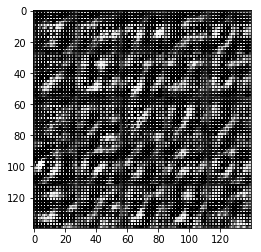

Epoch 1/2... , step 200 / 937 Discriminator Loss: 1.2114... Generator Loss: 1.5009


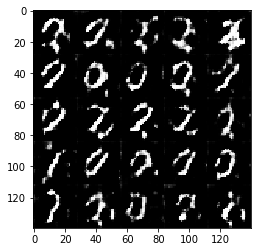

Epoch 1/2... , step 300 / 937 Discriminator Loss: 1.3816... Generator Loss: 0.5965


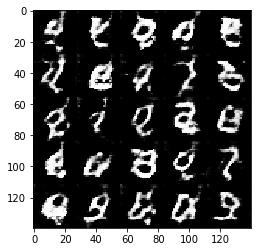

Epoch 1/2... , step 400 / 937 Discriminator Loss: 1.3089... Generator Loss: 0.5534


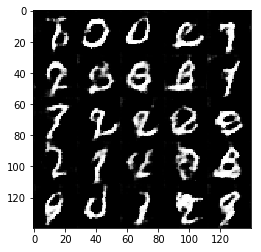

Epoch 1/2... , step 468 / 937 Discriminator Loss: 1.2835... Generator Loss: 1.1939


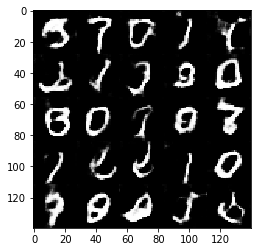

epoch 2
Epoch 2/2... , step 500 / 937 Discriminator Loss: 1.3734... Generator Loss: 0.5716


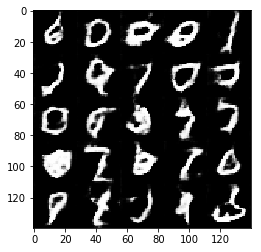

Epoch 2/2... , step 600 / 937 Discriminator Loss: 1.4232... Generator Loss: 0.5237


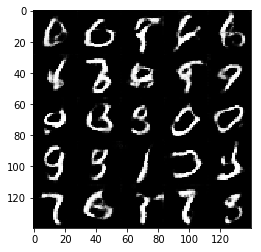

Epoch 2/2... , step 700 / 937 Discriminator Loss: 1.4264... Generator Loss: 0.7480


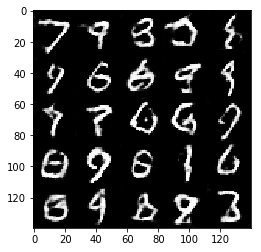

Epoch 2/2... , step 800 / 937 Discriminator Loss: 1.3075... Generator Loss: 1.4750


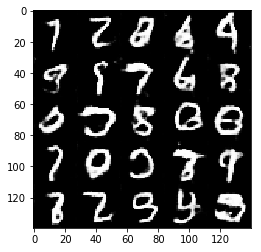

Epoch 2/2... , step 900 / 937 Discriminator Loss: 1.4253... Generator Loss: 2.5161


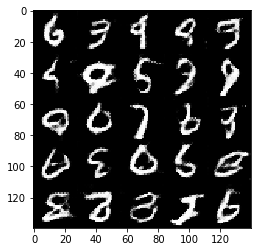

Epoch 2/2... , step 936 / 937 Discriminator Loss: 1.2418... Generator Loss: 0.6832


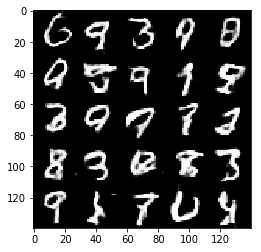

In [33]:
from datetime import datetime

batch_size = 128
z_dim = 100
#learning_rate = 0.00005
learning_rate = 0.002
beta1 = 0.5

print('-------------------------------')
print(str(datetime.now()), 'MNIST training...')


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

-------------------------------
2017-10-15 15:27:34.019500 CELEBA training...
1 64 200 0.001 0.5 (202599, 28, 28, 3) RGB
discriminator(), relu1 (?, 14, 14, 64)
discriminator(), relu2 (?, 7, 7, 128)
discriminator(), relu3 (?, 4, 4, 256)
discriminator(), relu1 (?, 14, 14, 64)
discriminator(), relu2 (?, 7, 7, 128)
discriminator(), relu3 (?, 4, 4, 256)
epoch 1
org data range: -0.5 0.5
scaled data range: -1.0 1.0
org data range: -0.5 0.5
scaled data range: -1.0 1.0
org data range: -0.5 0.5
scaled data range: -1.0 1.0
Epoch 1/1... , step 100 / 3165 Discriminator Loss: 0.3660... Generator Loss: 3.8968


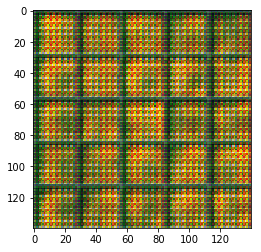

Epoch 1/1... , step 200 / 3165 Discriminator Loss: 0.3431... Generator Loss: 4.8348


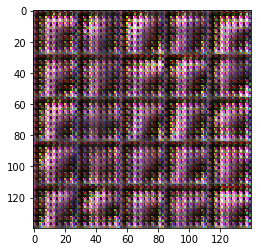

Epoch 1/1... , step 300 / 3165 Discriminator Loss: 1.1273... Generator Loss: 1.1310


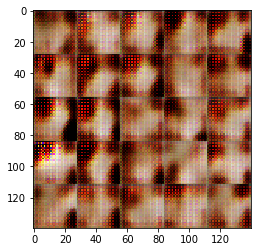

Epoch 1/1... , step 400 / 3165 Discriminator Loss: 1.4157... Generator Loss: 0.4661


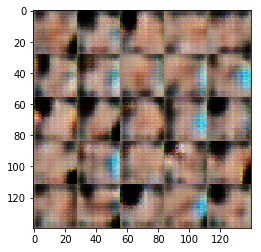

Epoch 1/1... , step 500 / 3165 Discriminator Loss: 1.1610... Generator Loss: 0.6883


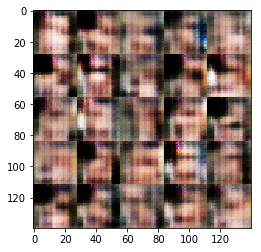

Epoch 1/1... , step 600 / 3165 Discriminator Loss: 0.9501... Generator Loss: 1.3869


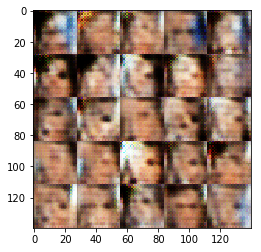

Epoch 1/1... , step 700 / 3165 Discriminator Loss: 0.9571... Generator Loss: 1.1059


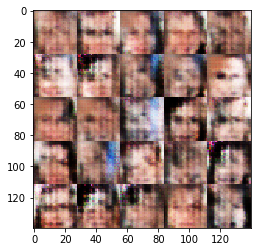

Epoch 1/1... , step 800 / 3165 Discriminator Loss: 1.4747... Generator Loss: 0.5368


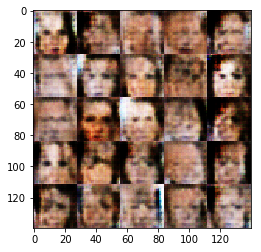

Epoch 1/1... , step 900 / 3165 Discriminator Loss: 1.6069... Generator Loss: 0.5841


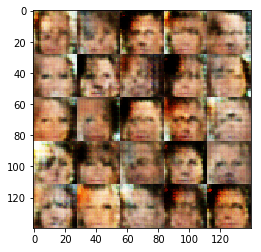

Epoch 1/1... , step 1000 / 3165 Discriminator Loss: 1.2225... Generator Loss: 0.9389


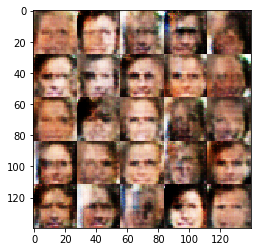

Epoch 1/1... , step 1100 / 3165 Discriminator Loss: 1.1058... Generator Loss: 0.9337


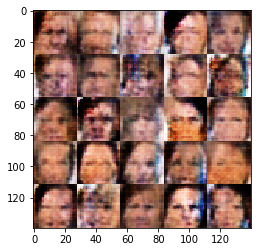

Epoch 1/1... , step 1200 / 3165 Discriminator Loss: 1.1591... Generator Loss: 0.9653


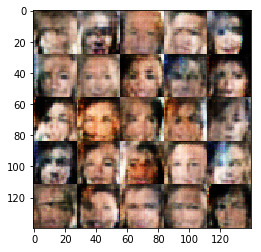

Epoch 1/1... , step 1300 / 3165 Discriminator Loss: 1.3992... Generator Loss: 1.0851


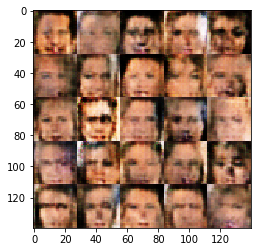

Epoch 1/1... , step 1400 / 3165 Discriminator Loss: 1.5112... Generator Loss: 0.8329


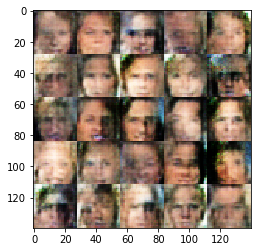

Epoch 1/1... , step 1500 / 3165 Discriminator Loss: 1.3177... Generator Loss: 0.6142


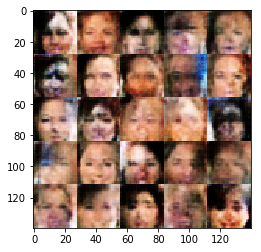

Epoch 1/1... , step 1600 / 3165 Discriminator Loss: 1.4672... Generator Loss: 0.5976


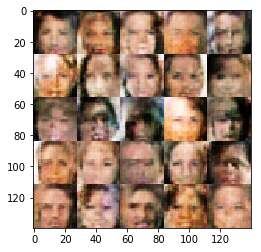

Epoch 1/1... , step 1700 / 3165 Discriminator Loss: 1.1071... Generator Loss: 0.9125


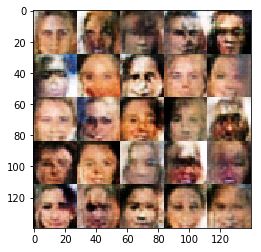

Epoch 1/1... , step 1800 / 3165 Discriminator Loss: 1.3187... Generator Loss: 0.6709


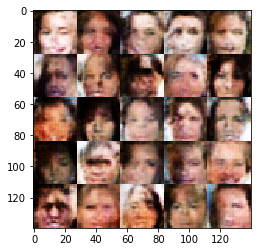

Epoch 1/1... , step 1900 / 3165 Discriminator Loss: 1.4409... Generator Loss: 0.4922


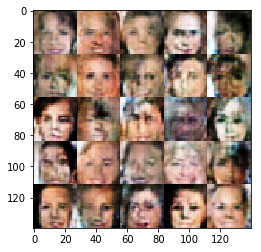

Epoch 1/1... , step 2000 / 3165 Discriminator Loss: 1.3879... Generator Loss: 0.7229


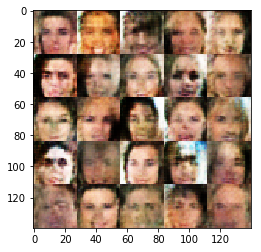

Epoch 1/1... , step 2100 / 3165 Discriminator Loss: 1.1163... Generator Loss: 0.8555


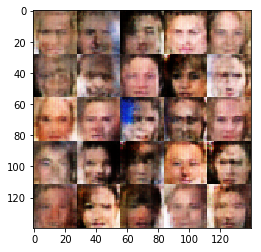

Epoch 1/1... , step 2200 / 3165 Discriminator Loss: 1.3760... Generator Loss: 0.8124


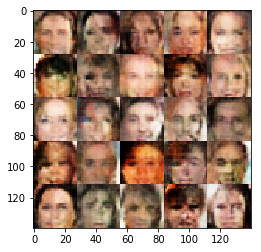

Epoch 1/1... , step 2300 / 3165 Discriminator Loss: 1.2179... Generator Loss: 0.8892


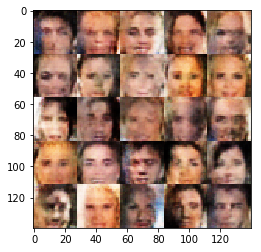

Epoch 1/1... , step 2400 / 3165 Discriminator Loss: 1.4221... Generator Loss: 0.7937


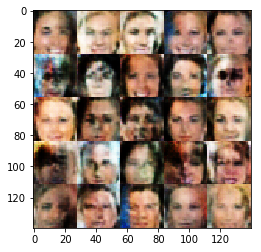

Epoch 1/1... , step 2500 / 3165 Discriminator Loss: 1.4786... Generator Loss: 0.4363


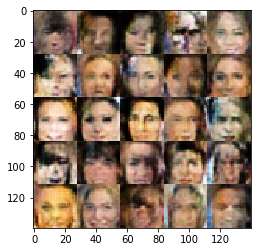

Epoch 1/1... , step 2600 / 3165 Discriminator Loss: 1.2942... Generator Loss: 0.7867


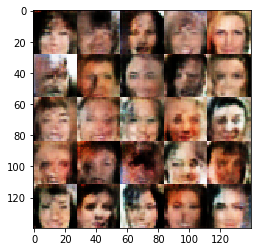

Epoch 1/1... , step 2700 / 3165 Discriminator Loss: 1.7265... Generator Loss: 0.4968


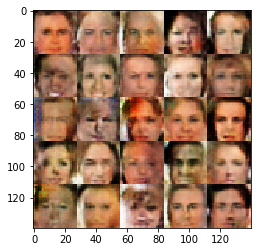

Epoch 1/1... , step 2800 / 3165 Discriminator Loss: 1.4366... Generator Loss: 0.5527


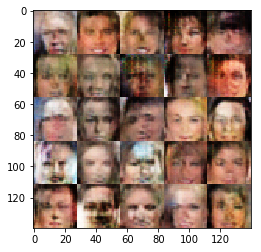

Epoch 1/1... , step 2900 / 3165 Discriminator Loss: 1.5972... Generator Loss: 0.5062


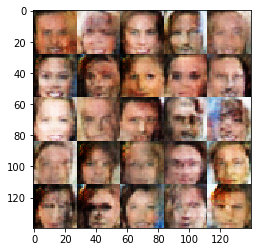

Epoch 1/1... , step 3000 / 3165 Discriminator Loss: 1.2188... Generator Loss: 0.7446


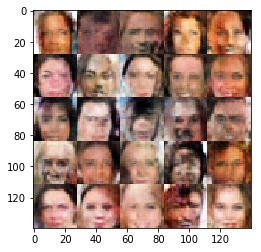

Epoch 1/1... , step 3100 / 3165 Discriminator Loss: 1.1955... Generator Loss: 0.7738


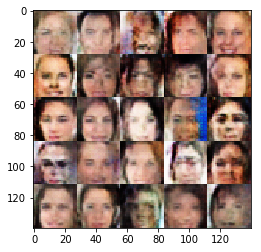

Epoch 1/1... , step 3165 / 3165 Discriminator Loss: 1.2489... Generator Loss: 0.8932


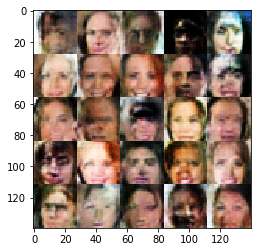

In [34]:
batch_size = 64
z_dim = 200
#learning_rate = 0.00005
learning_rate = 0.001
beta1 = 0.5

print('-------------------------------')
print(str(datetime.now()), 'CELEBA training...')

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。